In [9]:
rawImagePath = "raw_images"
datasetImagePath = "dataset/images"

In [10]:
import os

rawImages = os.listdir(rawImagePath)
datasetImages = os.listdir(datasetImagePath)

datasetImageSet = set(map(lambda x: f"{x.split('_JPG')[0]}.JPG", datasetImages))

geoImages = list(filter(lambda x: x in datasetImageSet, rawImages))

In [11]:
print(len(rawImages))
print(len(datasetImages))
print(len(geoImages))

3586
2125
1799


In [12]:
import PIL.Image
import PIL.ExifTags

img_metadata = {}

for i, geoImage in enumerate(geoImages):
    # Parse exif data
    img = PIL.Image.open(f"{rawImagePath}/{geoImage}")
    exif = {PIL.ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in PIL.ExifTags.TAGS}
    exif['GPSInfo'] = {PIL.ExifTags.GPSTAGS[k]: v for k, v in exif['GPSInfo'].items() if k in PIL.ExifTags.GPSTAGS}
    
    # Extract parameters
    lat = (1 if exif['GPSInfo']['GPSLatitudeRef'] == 'N' else -1) * (float(exif['GPSInfo']['GPSLatitude'][0]) + float(exif['GPSInfo']['GPSLatitude'][1]) / 60 + float(exif['GPSInfo']['GPSLatitude'][2]) / 3600)
    long = (1 if exif['GPSInfo']['GPSLongitudeRef'] == 'E' else -1) * (float(exif['GPSInfo']['GPSLongitude'][0]) + float(exif['GPSInfo']['GPSLongitude'][1]) / 60 + float(exif['GPSInfo']['GPSLongitude'][2]) / 3600)
    sealevelAlt = float(exif['GPSInfo']['GPSAltitude'])

    date = exif['DateTimeOriginal']
    year = int(date[:4])
    dayOfYear = (365/12) * (int(date[5:7]) - 1) + int(date[8:10])
    timeOfDay = int(date[11:13]) + int(date[14:16]) / 60 + int(date[17:19]) / 3600

    img_metadata[geoImage] = {'lat': lat, 'long': long, 'sealevelAlt': sealevelAlt, 'year': year, 'dayOfYear': dayOfYear, 'timeOfDay': timeOfDay}

sealevelAlts = [m['sealevelAlt'] for m in img_metadata.values()]
years = [m['year'] for m in img_metadata.values()]
dayOfYears = [m['dayOfYear'] for m in img_metadata.values()]
timeOfDays = [m['timeOfDay'] for m in img_metadata.values()]
coordinates = [f"{m['lat']:.7f}, {m['long']:.7f}\n" for m in img_metadata.values()]

In [13]:
import requests
import concurrent.futures
from pyproj import Proj

def getGroundAlt(key, lat, long):
    # Convert to UTM zone 33
    proj = Proj("+proj=utm +zone=33 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    UTMx, UTMy = proj(long, lat)
    value = requests.get('https://hoydedata.no/arcgis/rest/services/NHM_DTM_25833/ImageServer/identify?f=json&geometryType=esriGeometryPoint&geometry={x: %f, y: %f,"spatialReference":{"wkid":25833,"latestWkid":25833}}' % (UTMx, UTMy)).json()["value"]
    return (key, float(value))


with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    i = 0
    futures = []
    for (key, m) in img_metadata.items():
        futures.append(executor.submit(getGroundAlt, key, m['lat'], m['long']))
    for future in concurrent.futures.as_completed(futures):
        (key, groundAlt) = future.result()
        img_metadata[key]['groundAlt'] = groundAlt
        img_metadata[key]['alt'] = img_metadata[key]['sealevelAlt'] - groundAlt
        i += 1
        print(f"Image {i} / {len(geoImages)}", end="\r")

groundAlts = [m['groundAlt'] for m in img_metadata.values()]
alts = [m['alt'] for m in img_metadata.values()]

In [104]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)

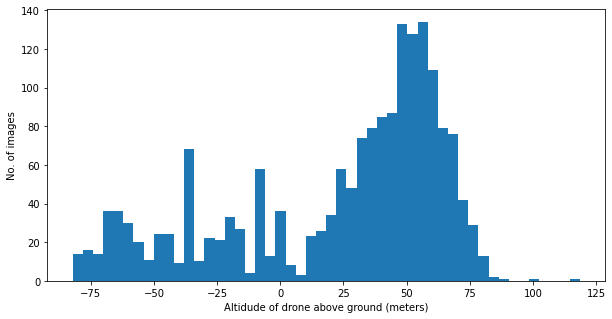

In [105]:
plt.hist(alts, bins=50)
plt.xlabel("Altidude of drone above ground (meters)")
plt.ylabel("No. of images")
plt.show()

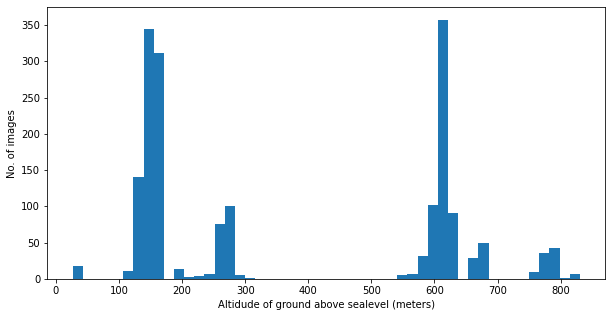

In [106]:
plt.hist(groundAlts, bins=50)
plt.xlabel("Altidude of ground above sealevel (meters)")
plt.ylabel("No. of images")
plt.show()

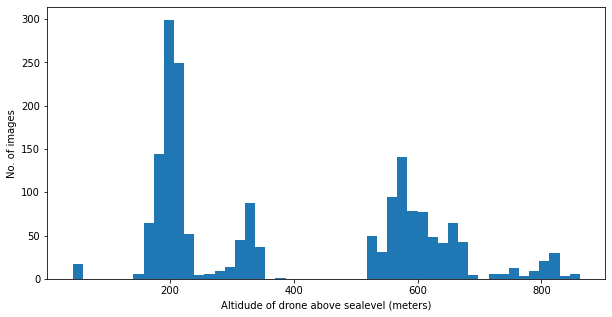

In [117]:
plt.hist(sealevelAlts, bins=50)
plt.xlabel("Altidude of drone above sealevel (meters)")
plt.ylabel("No. of images")
plt.show()

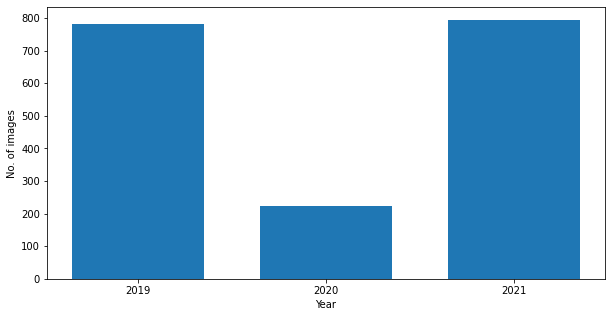

In [108]:
plt.hist(years, bins=[2019, 2020, 2021, 2022], rwidth=.7, align="left")
plt.xticks([2019, 2020, 2021])
plt.xlabel("Year")
plt.ylabel("No. of images")
plt.show()

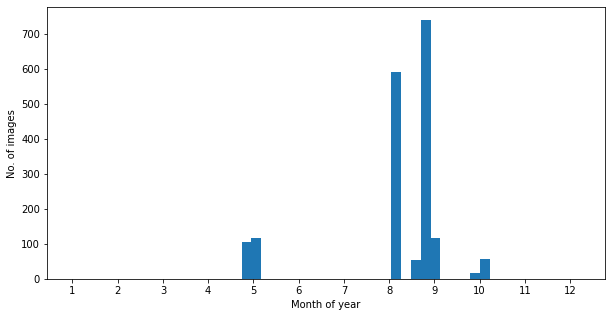

In [109]:
import numpy as np

plt.hist(dayOfYears, bins=np.linspace(0,372,52))
plt.xticks(np.linspace(0,365,12), np.arange(12) + 1)
plt.xlabel("Month of year")
plt.ylabel("No. of images")
plt.show()

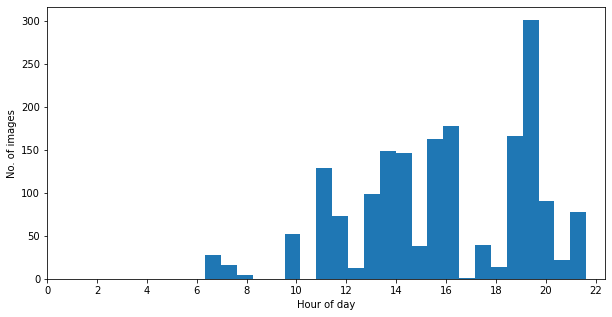

In [110]:
plt.hist(timeOfDays, bins=24)
plt.xticks(np.arange(0, 24, 2))
plt.xlabel("Hour of day")
plt.ylabel("No. of images")
plt.show()